In [1]:
%matplotlib inline

In [2]:
import pandas as pd

# Load the dream5 dataset
Please download the following datasets from the [dream5 dedicated website](https://www.synapse.org/#!Synapse:syn3130840) (you need to create an account first):


+ `net3_expression_data.tsv`: E. coli gene expression data (MicroArray)
+ `net3_transcription_factors.tsv`: transcription factor genes

### Load the datasets
+ Load the gene expression dataset $X$

In [3]:
X = pd.read_csv("net3_expression_data.tsv",sep="\t").T # rows represent genes and columns represent conditions

+ Load the Transcription Factors list

In [4]:
tf = pd.read_csv("net3_transcription_factors.tsv",header=None)[0]

# Preprocessing

Apply a simple z-score gene-wise (axis=0)

In [5]:
from grenadine.Preprocessing.standard_preprocessing import z_score

In [6]:
X = z_score(X,axis=1)

# Infer the GRN
+ Load the score links function and SVM classification method

In [7]:
from grenadine.Inference.inference import score_links
from grenadine.Inference.classification_predictors import SVM_classifier_score

/Users/sergiopeignier/Documents/libraries/grenadine/grenadine/Inference/inference.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


+ Choose the parameters of the underlying SVM method

(the parameters are the same as those of [sklearn SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html))

In this tutorial we set two parameters:
- C (float): the $l_2$ regularization strength is inversely proportional to C, higher values of C incur in larger runtimes, and more complex models (overfitting is a risk if C is too high). Low values of C incur in lower runtimes and simpler models (underfitting is a risk if C is too low)
- tol (float) Tolerance for early stopping criterion

In [8]:
SVM_params = {"C":0.001,"tol":1e-3}

+ Build a discretization method to run the classification algorithm on discrete classes using `discretize_genexp`
- "method" defines the discretization methodology, we suggest to use "kmeans" as default method
- "bins" defines the number of discrete classes for each TG level of expression. We suggest to use 5 discrete classes. Few classes tend to run faster, but results are poorer.

In [9]:
from grenadine.Preprocessing.discretization import discretize_genexp
method = "kmeans"
bins = 5
kmeans_discretizer = lambda x: discretize_genexp(x, method, bins)

+ Score all the possible edges between Transcription Factors and Target Genes

In [10]:
score_matrix = score_links(gene_expression_matrix=X,
                           score_predictor=SVM_classifier_score,
                           tf_list=tf,
                           discr_method=kmeans_discretizer,
                           progress_bar=True,
                           **SVM_params)

# Visualize the results

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
score_matrix.shape

(4511, 334)

The following heatmap represents the coefficients (scores) matrix

Text(33.0, 0.5, 'TGs')

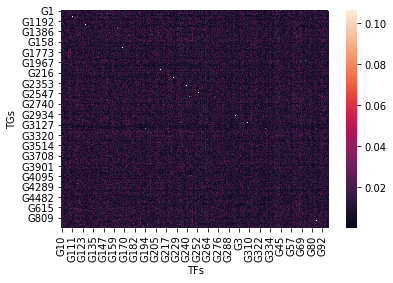

In [13]:
sns.heatmap(score_matrix)
plt.xlabel("TFs")
plt.ylabel("TGs")

Selecting only top scores above a given threshold can provide a GRN

Text(33.0, 0.5, 'TGs')

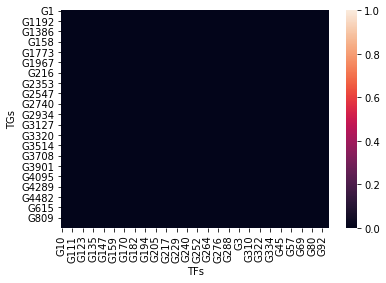

In [14]:
sns.heatmap(score_matrix>=0.1)
plt.xlabel("TFs")
plt.ylabel("TGs")

The distribution of scores can be used to set a threshold

Text(0, 0.5, 'Frequencies')

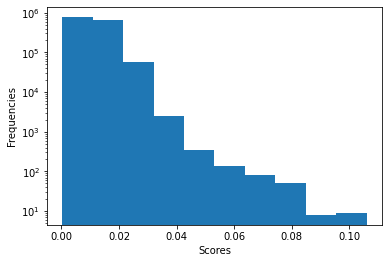

In [15]:
_=plt.hist(score_matrix.values.flatten() ,log=True)
plt.xlabel("Scores")
plt.ylabel("Frequencies")

# Rank the links according to their scores

In [16]:
from grenadine.Inference.inference import rank_GRN
ranking = rank_GRN(score_matrix)

In [17]:
ranking.head(20)

rank     score    TF     TG
G261_G1080   1.0  0.106103  G261  G1080
G194_G329    2.0  0.102886  G194   G329
G329_G194    3.0  0.100574  G329   G194
G261_G1768   4.0  0.099599  G261  G1768
G261_G525    5.0  0.098983  G261   G525
G116_G2990   6.0  0.098914  G116  G2990
G261_G1530   7.0  0.098598  G261  G1530
G261_G1792   8.0  0.098129  G261  G1792
G187_G2989   9.0  0.097383  G187  G2989
G187_G1195  10.0  0.094304  G187  G1195
G110_G219   11.0  0.091695  G110   G219
G116_G4206  12.0  0.091560  G116  G4206
G234_G3959  13.0  0.090840  G234  G3959
G219_G110   14.0  0.089500  G219   G110
G116_G1284  15.0  0.089108  G116  G1284
G261_G1062  16.0  0.086911  G261  G1062
G246_G243   17.0  0.086735  G246   G243
G194_G4175  18.0  0.084595  G194  G4175
G194_G3630  19.0  0.083517  G194  G3630
G78_G3598   20.0  0.083305   G78  G3598

# Plot the top 100 edges GRN using networkx
Convert the top 100 edges to a NetworkX DiGraph

In [59]:
from grenadine.Evaluation.evaluation import rank_to_networkx
grn_inferred_top100 = rank_to_networkx(ranking, top_n=500)

Plot the network using NetworkX 

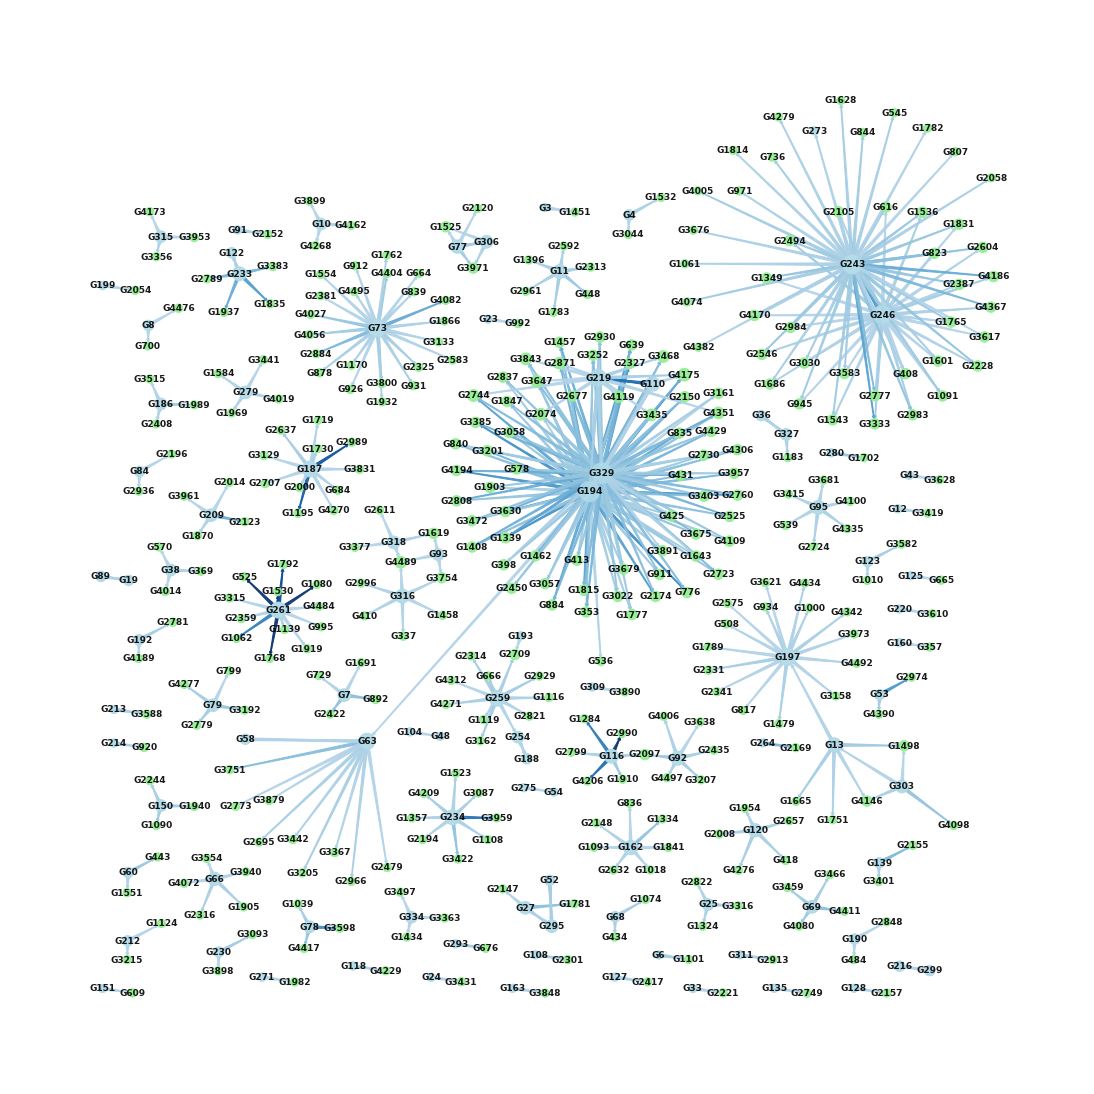

In [62]:
import networkx as nx
import numpy as np
# Define the colors of the nodes
colnodes = []
for node in grn_inferred_top100:
    if node in tf.values:
        colnodes.append('lightBlue')
    else: 
        colnodes.append('lightGreen') 

# Define scores for the edge colors as 1/(log(rank)+1) 
edge_colors = []
for edge in grn_inferred_top100.edges():
    edge_colors.append(1/np.log(grn_inferred_top100[edge[0]][edge[1]]["rank"]+1))

# Define the fire size
plt.figure(figsize=(15,15))

# Define the node size prop. to its degree
nodes_degrees = dict(grn_inferred_top100.degree)

# Plot the network
# neato, dot, twopi, circo, fdp, sfdp.
nx.draw(grn_inferred_top100,edge_cmap=plt.cm.Blues,
        pos = nx.nx_agraph.graphviz_layout(grn_inferred_top100,prog="fdp"),
        node_color=colnodes,edge_color = edge_colors,edge_vmin=0.01,edge_vmax=0.5,
        with_labels = True,alpha=0.9,font_size=9,font_weight="bold",
        arrowsize=7, arrowstyle='fancy',node_shape="o",width=1,
        node_size=[np.log(nodes_degrees[k]+1)*100 for k in nodes_degrees])


# Evalute the Results
+ Download `DREAM5_NetworkInference_GoldStandard_Network3 - E. coli.tsv` the gold standard dataset from the [dream5 website](https://www.synapse.org/#!Synapse:syn2787213)
+ Load the gold standard

In [20]:
grn = pd.read_csv("DREAM5_NetworkInference_GoldStandard_Network3 - E. coli.tsv",sep="\t",header=None)
# Rename the columns and the index
grn.columns = ["TF","TG","IS_REGULATED"]
grn.index = grn["TF"]+"_"+grn["TG"]
# Drop duplicate rows
grn = grn.drop_duplicates()

+ Load the `evaluate_result` function 

In [21]:
from grenadine.Evaluation.evaluation import evaluate_result

In [22]:
metrics = evaluate_result(score_matrix, grn, n_links=100000)

In [23]:
metrics

AUROC        0.774143
AUPR         0.304293
Precision    0.116879
Recall       0.667219
Accuracy     0.745651
F1           0.198914
dtype: float64